In [1]:
using PyPlot
using NLsolve

if length(LOAD_PATH) < 3
    push!(LOAD_PATH,"/Users/wrsweeney/Box Sync/Research/SALT")
#    push!(LOAD_PATH,"/home/wrs28/Documents/SALT")
end

if nprocs() == 1
    addprocs(3)
#     addprocs(20)
end

using SALT_1d
using SALT_1d_Parallel

In [133]:
ng = 50
nk = 3
nd = 20

N = 1501
Γ = linspace(100,.0001,ng)
D = linspace(0,-.1,nd)
;

In [134]:
inputs = processInputs()
inputs["N"] = N

inputs["Γ"] = [ Inf     100     10    Γ[1]    Inf]
inputs = updateInputs(inputs)

kR = NaN*zeros(Complex128,ng,nk)
ψR = NaN*zeros(Complex128,inputs["N_ext"],ng,nk)
kL = copy(kR)
ψL = NaN*zeros(Complex128,inputs["N_ext"],ng,nk)

kR[1,:],ψR[:,1,:] = computeULRs(inputs,40.75, nk; direction = "R", F=0.)
kL[1,:],ψL[:,1,:] = computeULRs(inputs,40.75, nk; direction = "L", F=0.)

for j in 1:nk
    for i in 2:ng

        inputs["Γ"] = [ Inf     100     10    Γ[i]    Inf]
        inputs = updateInputs(inputs)

        temp1, temp2 = computeULRs(inputs, kR[i-1,j], 1; direction = "R", F=0.)
        kR[i,j] = temp1[1]
        ψR[:,i,j] = temp2[:,1]
        temp1, temp2 = computeULRs(inputs, kL[i-1,j], 1; direction = "L", F=0.)
        kL[i,j] = temp1[1]
        ψL[:,i,j] = temp2[:,1]

    end
end

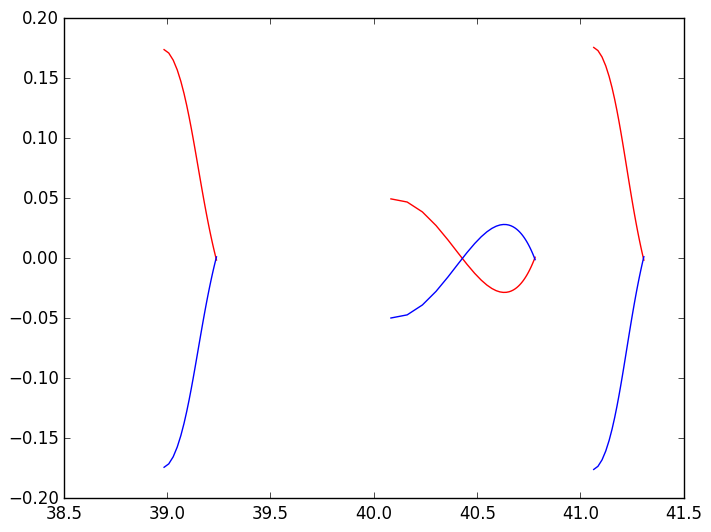

In [135]:
plot(real(kR),imag(kR),"r-")
plot(real(kL),imag(kL),"b-")
;

In [137]:
kR[:,1]

50-element Array{Complex{Float64},1}:
          40.7813+0.00099907im 
          40.7803+0.000508971im
 40.7791+1.78578e-6im          
          40.7779-0.000523289im
          40.7767-0.00106709im 
          40.7754-0.00163051im 
           40.774-0.00221447im 
          40.7726-0.00281992im 
          40.7711-0.00344787im 
          40.7695-0.00409935im 
          40.7678-0.00477543im 
           40.766-0.00547719im 
          40.7641-0.00620575im 
                 ⋮             
           40.593-0.0268704im  
          40.5721-0.0250483im  
          40.5482-0.0222038im  
          40.5207-0.0180822im  
          40.4889-0.0124142im  
          40.4521-0.00496194im 
          40.4094+0.00438442im 
          40.3596+0.0154331im  
           40.302+0.0274274im  
          40.2359+0.0387698im  
          40.1623+0.0470221im  
          40.0837+0.0496306im  

In [1]:
plot(abs2(ψR[:,45,1]))
plot(abs2(ψL[:,45,1]))

LoadError: UndefVarError: plot not defined

In [101]:
inputs = processInputs()
inputs["N"] = N
inputs["Γ"] = [ Inf     100     Inf    Γ[end]    Inf]
inputs = updateInputs(inputs)

kkR = NaN*zeros(Complex128,nd,nk)
kkL = copy(kkR)
kkR[1,:] = kR[end,:]
kkL[1,:] = kL[end,:]

for j in 1:nk
    for i in 2:nd
        inputs["D₀"] = D[i]
        kkR[i,j] = computeULRs(inputs, kkR[i-1,j], 1; direction = "R", F=1.)[1][1]
        kkL[i,j] = computeULRs(inputs, kkL[i-1,j], 1; direction = "L", F=1.)[1][1]
    end
end

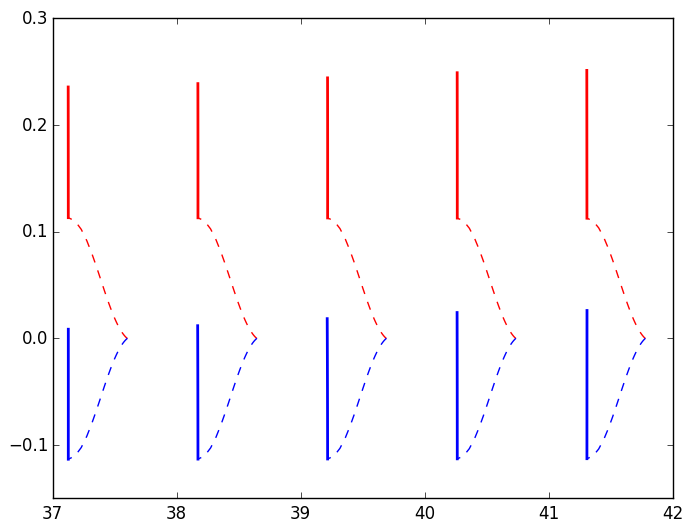

In [102]:
plot(real(kR),imag(kR),"r--")
plot(real(kL),imag(kL),"b--")
plot(real(kkL),imag(kkL),"b-",lw=2.)
plot(real(kkR),imag(kkR),"r-",lw=2.)

;

In [ ]:
#verify computeCFs
inputs = processInputs()
η,u = computeCFs(inputs,inputs["k₀"]+.1im,10)
inputs["bc"] = ["pml_in" "pml_in"]
β,v = computeCFs(inputs,inputs["k₀"]+.1im,10)
inputs["bc"] = ["in" "in"]
γ,s = computeCFs(inputs,inputs["k₀"],10)

figure(1)
title("Outgoing TCF evals (x's) and incoming TCF evals (o's) for non-uniformly pumped cavity.")
plot(real(β),imag(β),"o")
plot(real(η),imag(η),"x")
plot(real(γ),imag(γ),"s")

figure(2)
title("TCF states, purely outgoing, at complex k+ig. Expect exponential decay.")
plot(abs2(u))

figure(3)
title("TCF states, purely incoming, at complex k+ig. Expect exponential growth.")
plot(abs2(v))

figure(4)
#title("TCF states, purely incoming, at complex k+ig. Expect exponential growth.")
plot(abs2(s))
;

In [ ]:
#verify computePolesL

inputs = processInputs()

nD = 10
nPoles = 3
D = linspace(-.25,0.25,nD)

kp = NaN*zeros(Complex128,nD,nPoles)
ψp = NaN*zeros(Complex128,nD,inputs["N_ext"],nPoles)
for d in 1:nD
    inputs["D₀"] = D[d]
    kp[d,:],ψp[d,:,:] = computePolesL(inputs, inputs["k₀"], nPoles; F=1.)
end

figure(1)
title("Trajectories of poles as n'' is varied uniformly. Circle indicates n''=0.")
plot(real(kp),imag(kp),"-x")
plot(real(kp[ceil(Int,nD/2),:]),imag(kp[ceil(Int,nD/2),:]),"o")
grid(true)

figure(2)
title("Wavefunctions associated with a pole at varying n''.")
plot(inputs["x_ext"],abs2(ψp[:,:,1]'))
;

In [ ]:
#verify computeZerosL

inputs = processInputs()

nD = 10
nZeros = 3
D = linspace(-.25,0.25,nD)

kz = NaN*zeros(Complex128,nD,nZeros)
ψz = NaN*zeros(Complex128,nD,inputs["N_ext"],nZeros)
for d in 1:nD
    inputs["D₀"] = D[d]
    kz[d,:],ψz[d,:,:] = computeZerosL(inputs, inputs["k₀"], nZeros; F=1.)
end

figure(1)
title("Trajectories of zeros as n'' is varied uniformly. Square indicates n''=0.")
plot(real(kz),imag(kz),"-o")
plot(real(kz[ceil(Int,nD/2),:]),imag(kz[ceil(Int,nD/2),:]),"s")
grid(true)

figure(2)
title("Wavefunctions associated with a zero at varying n''.")
plot(inputs["x_ext"],abs2(ψz[:,:,1]'))
;

In [ ]:
#verify computePolesNL1

inputs = processInputs()

nD = 10
D = linspace(0,0.4,nD)
nPoles = 5

kp_init, ψp_init = computePolesL(inputs,inputs["k₀"],nPoles;F=1.)

kp = NaN*zeros(Complex128,nD,nPoles)
ψp = NaN*zeros(Complex128,nD,inputs["N_ext"],nPoles)
η = 0

for n in 1:nPoles
    for d in 1:nD
        if d/3==round(d/3)
            println([n,d])
        end
        inputs["D₀"] = D[d]
        if d==1
            kp[d,n],ψp[d,:,n],η,conv = computePolesNL1(inputs, kp_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kp[d,n],ψp[d,:,n],η,conv = computePolesNL1(inputs, kp[d-1,n] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, η_init = η, u_init = ψp[d-1,:,n] )
        end
    end
end

figure(1)
plot(real(kp),imag(kp),"-x")

figure(2)
plot(abs2(ψp[:,:,1])')    
;

In [ ]:
#verify computeZerosNL1

inputs = processInputs()

nD = 10
D = linspace(0,-0.4,nD)
nZeros = 5

kz_init, ψz_init = computeZerosL(inputs,inputs["k₀"],nZeros;F=1.)

kz = NaN*zeros(Complex128,nD,nZeros)
ψz = NaN*zeros(Complex128,nD,inputs["N_ext"],nZeros)
β = 0

for n in 1:nZeros
    for d in 1:nD
        if d/3==round(d/3)
            println([n,d])
        end
        inputs["D₀"] = D[d]
        if d==1
            kz[d,n],ψz[d,:,n],β,conv = computeZerosNL1(inputs, kz_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kz[d,n],ψz[d,:,n],β,conv = computeZerosNL1(inputs, kz[d-1,n] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, β_init = β, v_init = ψz[d-1,:,n] )
        end
    end
end

figure(1)
plot(real(kz),imag(kz),"-x")

figure(2)
plot(abs2(ψz[:,:,1])')    
;

In [ ]:
# verify computePolesNL2

inputs = processInputs()

nD = 10
D = linspace(0,0.4,nD)

kpp1 = Array(Any,nD)
kpp2 = Array(Any,nD)

tic()
for d in 1:nD
    println(d)
    inputs["D₀"] = D[d]
    kpp1[d] = computePolesNL2(inputs, inputs["k₀"], (2.5,1.4); Nq=150, nPoles=7, F=1., R_min = .01)
end
toc()

tic()
for d in 1:nD
    println(d)
    inputs["D₀"] = D[d]
    kpp2[d] = computePolesNL2_parallel(inputs, inputs["k₀"], (2.5,1.4); Nq=150, nPoles=7, F=1., R_min = .01)
end
toc()

for d in 1:nD
    plot(real(kpp1[d]),imag(kpp1[d]),"s")
    plot(real(kpp2[d]),imag(kpp2[d]),"o")
end
;

In [ ]:
#verifying that computePolesNL1 and computePolesNL2 agree

figure(1)
plot(real(kp),imag(kp),"-x")

for d in 1:nD
    plot(real(kpp1[d]),imag(kpp1[d]),"o", mfc = "none")
    plot(real(kpp2[d]),imag(kpp2[d]),"s", mfc = "none")
end

In [ ]:
# verify computeZerosNL2

inputs = processInputs()

nD = 10
D = linspace(0,-0.4,nD)

kzz1 = Array(Any,nD)
kzz2 = Array(Any,nD)

tic()
for d in 1:nD
    println(d)
    inputs["D₀"] = D[d]
    kzz1[d] = computeZerosNL2(inputs, inputs["k₀"], (2.75,.4); Nq=150, nZeros=7, F=1., R_min = .01)
end
toc()

tic()
for d in 1:nD
    println(d)
    inputs["D₀"] = D[d]
    kzz2[d] = computeZerosNL2_parallel(inputs, inputs["k₀"], (2.75,.4); Nq=150, nZeros=7, F=1., R_min = .01)
end
toc()

for d in 1:nD
    plot(real(kzz1[d]),imag(kzz1[d]),"s")
    plot(real(kzz2[d]),imag(kzz2[d]),"o")
end
;

In [ ]:
#verifying that computeZerosNL1 and computeZerosNL2 agree

figure(1)
plot(real(kz),imag(kz),"-x")

for d in 1:nD
    plot(real(kzz1[d]),imag(kzz1[d]),"o", mfc = "none")
    plot(real(kzz2[d]),imag(kzz2[d]),"s", mfc = "none")
end

In [ ]:
#verify solve_scattered linear

inputs = processInputs()
inputs["a"] = [1,0]
inputs["D₀"] = 0.015
inputs["Γ"][2]   = 5
inputs["Γ_ext"][2+2] = inputs["Γ"][2]
inputs["Γ"][4]   = 5
inputs["Γ_ext"][4+2] = inputs["Γ"][4]
k = 20.2

ψL = solve_scattered(inputs,k; F=1., truncate = true)

figure(1)
plot(inputs["x"],real(ψL))

figure(2)
plot(inputs["x"],imag(ψL))

figure(3)
plot(inputs["x"],abs2(ψL))
;

In [ ]:
#verify solve_scattered nonlinear

inputs = processInputs()
inputs["a"] = [1,0]
inputs["D₀"] = 0.015
inputs["Γ"][2]   = 5
inputs["Γ_ext"][2+2] = inputs["Γ"][2]
inputs["Γ"][4]   = 5
inputs["Γ_ext"][4+2] = inputs["Γ"][4]
k = 20.2

ψR = solve_scattered(inputs,k; F=1., truncate = true, isNonLinear = true, dispOpt = true)

figure(1)
plot(inputs["x"],real(ψR))

figure(2)
plot(inputs["x"],imag(ψR))

figure(3)
plot(inputs["x"],abs2(ψR))
;

In [ ]:
# compare nonlinear and linear scattering
plot(inputs["x"],abs2(ψL),"b")
plot(inputs["x"],abs2(ψR),"r")
;

In [ ]:
#verify S-matrix linear
inputs = processInputs()

tic()
S1 = computeS(inputs; N=1, isNonLinear = false, F=1., dispOpt = false)
toc()
SL = S1[:,:,:,end]

tic()
S2,r = computeS_parallel(inputs; N=1, isNonLinear = false, F=1., dispOpt = false)
S_wait(r)
toc()
SL2 = S2[:,:,:,end]


figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(SL[1,1,:]),"r")
plot(inputs["k"],abs2(SL[2,1,:]),"b")
plot(inputs["k"],abs2(SL[1,1,:])+abs2(S1[2,1,:])-1,"k")

plot(inputs["k"],abs2(SL2[1,1,:]),"r--",lw=2)
plot(inputs["k"],abs2(SL2[2,1,:]),"b--",lw=2)
plot(inputs["k"],abs2(SL2[1,1,:])+abs2(SL2[2,1,:])-1,"k--",lw=2)
;

In [ ]:
#verify S-matrix nonlinear
inputs = processInputs()

tic()
S2,r = computeS_parallel(inputs; N=10, N_Type="A", isNonLinear = true, F=1., dispOpt=false)
S_wait(r)
toc()
SNL = S2[:,:,:,end]

tic()
S1 = computeS(inputs; N=10, isNonLinear = true, F=1., dispOpt=false)
toc()
SNL2 = S1[:,:,:,end]


figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(SNL[1,1,:]),"r")
plot(inputs["k"],abs2(SNL[2,1,:]),"b")
plot(inputs["k"],abs2(SNL[1,1,:])+abs2(SNL[2,1,:])-1,"k")

plot(inputs["k"],abs2(SNL2[1,1,:]),"r--",lw=2.)
plot(inputs["k"],abs2(SNL2[2,1,:]),"b--",lw=2.)
plot(inputs["k"],abs2(SNL2[1,1,:])+abs2(SNL2[2,1,:])-1,"k--",lw=2.)
;

In [ ]:
# compare linear vs nonlinear S-matrix

figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(SL[1,1,:]),"r--",lw=2)
plot(inputs["k"],abs2(SL[2,1,:]),"b--",lw=2)
plot(inputs["k"],abs2(SL[1,1,:])+abs2(SL[2,1,:])-1,"k--",lw=2)
plot(inputs["k"],abs2(SNL[1,1,:]),"r",lw=1)
plot(inputs["k"],abs2(SNL[2,1,:]),"b",lw=1)
plot(inputs["k"],abs2(SNL[1,1,:])+abs2(SNL[2,1,:])-1,"k",lw=1)
;

In [ ]:
# check that loss is consistent in bulk vs boundary for linear case

S = SL

inputs = processInputs()
inputs["a"] = [1.,0.]

r = SALT_1d.Core.whichRegion(inputs["x"],inputs["∂"])
F = inputs["F"][r]
loss1 = NaN*zeros(Float64,length(inputs["k"]))
loss2 = copy(loss1)

for k_ind = 1:length(inputs["k"])
    k = inputs["k"][k_ind]
    ψ = solve_scattered(inputs, k; truncate = true, isNonLinear = false)
    ɛ = inputs["ɛ"][r]+inputs["D₀"]*F*inputs["γ⟂"]/(k-inputs["k₀"]+1im*inputs["γ⟂"])

    loss1[k_ind] = abs2(S[1,1,k_ind])+abs2(S[2,1,k_ind])-1
    loss2[k_ind] = inputs["k"][k_ind]*real(SALT_1d.Core.trapz(-imag(ɛ).*abs2(ψ),inputs["dx"]))
end

title(L"Gain as $r^2+t^2-1$ (b-) and bulk gain computed via $\psi$ (r--)")
plot(inputs["k"],loss1,"b"  ,lw = 1.5)
plot(inputs["k"],loss2,"--r",lw = 2.)
;

In [ ]:
# # TEST SPA scattered
# inputs["a"] = 1.
# inputs["D₀"] = .2
# ψ₊,ψ₋,(z₊,z₋,φ₊,φ₋,η,u) = solve_SPA(inputs, real(ω1[1]), z₀₊=.15im, z₀₋=1.5im)

# plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
# hold(true)
# plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]))

In [ ]:
# # TEST SPA Lasing
# a = copy(inputs["a"])
# inputs["a"] = 0.
# inputs["D₀"] = D2
# ψ₊,ψ₋,dummy = solve_SPA(inputs, real(ω1[1]),z₀₊=.0001im,z₀₋=.0001im)

# plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
# hold(true)a
# plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]));

In [ ]:
# # TEST LASING SOLVER
# ψ₊ = 1im*ψ₊/exp(1im*angle(ψ₊[1]))
# ψ₋ = 1im*ψ₋/exp(1im*angle(ψ₋[1]))
# ψ,ω = solve_lasing(inputs, inputs["D₀"], ψ_init=ψ₊,ω_init = real(ω1[1]), inds = 14)
# ω